In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import fftconvolve
from scipy.fft import fft2, ifft2

In [53]:
img = cv2.imread("cat2.jpg")

In [54]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [55]:
img.shape

(445, 445)

In [56]:
img = img.astype(np.float64)

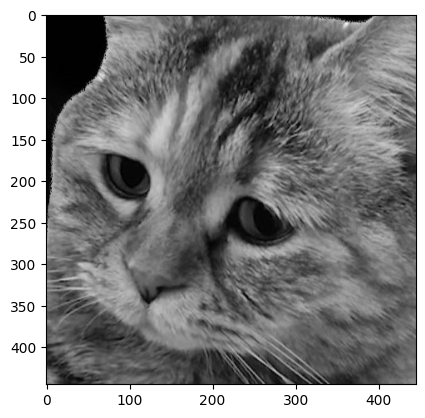

In [57]:
plt.imshow(img, cmap='gray')

In [58]:
mean = 0
sigma = 10
gaussian = np.random.normal(mean, sigma, img.shape)#.astype(np.uint8)

In [59]:
gaussian

array([[ -2.70524667,   1.47826411,  -8.71802866, ...,  -6.72579193,
          1.55060115,   7.04926482],
       [  0.47542551, -23.57028014,  10.88093671, ...,  -3.75130827,
          2.93847296,   6.53067006],
       [ -0.80170808,  -6.32240312,  -0.89807574, ..., -12.18851471,
         -2.57528713,  -1.30049069],
       ...,
       [-11.36303523,  -1.87027905,   4.08834847, ...,   9.22286024,
          9.60495811,  -3.56487278],
       [ -9.36107146,   9.16346959, -10.17350149, ...,  10.66506582,
        -18.9311212 ,   0.12093678],
       [-11.44448393,  12.66511494,  -5.48649985, ...,  19.01949077,
         12.64442791,  -7.77352093]])

In [60]:
img

array([[  1.,   1.,   1., ..., 113., 115., 116.],
       [  1.,   1.,   1., ..., 113., 114., 116.],
       [  1.,   1.,   1., ..., 110., 109., 111.],
       ...,
       [105., 108., 109., ..., 107., 106., 105.],
       [101., 102., 102., ..., 107., 107., 106.],
       [ 95.,  96.,  95., ..., 107., 107., 106.]])

### Plain image with guassian noise

In [34]:
noisy = cv2.add(img, gaussian)

In [61]:
noisy

array([[   5.87447705,  -16.95471148, -100.19379594, ...,  147.09891093,
         116.66290527,  145.32724635],
       [  16.5920621 ,    6.59126764,  -74.37079051, ...,  151.53665889,
          82.19871078,   42.57658513],
       [ -20.80556087,  102.74622154,   59.21386824, ...,  121.61576633,
         157.7840339 ,  169.46154674],
       ...,
       [ 183.25001362,   63.45448364,  135.58777396, ...,   93.81225346,
          81.57171682,   80.52637127],
       [ 206.46541024,  112.11303333,  112.62557052, ...,   27.47826012,
         115.42148249,  135.60462949],
       [  43.72899158,    1.77342012,   79.22050248, ...,  108.49218816,
         140.08964727,   72.01703625]])

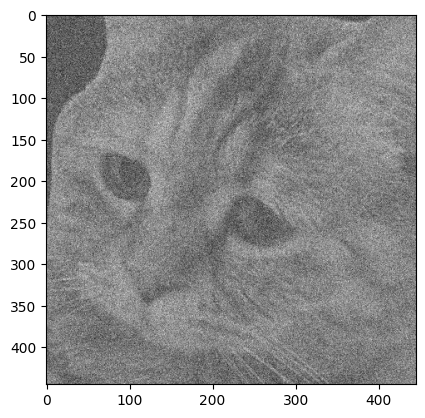

In [62]:
plt.imshow(noisy, cmap='gray')

In [43]:
cv2.PSNR(img, noisy)

14.169943474815694

## Wiener Filter

In [38]:
def wiener_filter(noisy_image, kernel, K):
    IMG = fft2(noisy_image)
    kernel = fft2(kernel, s = noisy_image.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    IMG = IMG * kernel
    filtered_image = np.abs(ifft2(IMG))
    return filtered_image

In [39]:
from scipy import signal

In [40]:
kernel = np.identity(3)
kernel /= 3

In [41]:
denoisy = wiener_filter(noisy, kernel, 0.5)

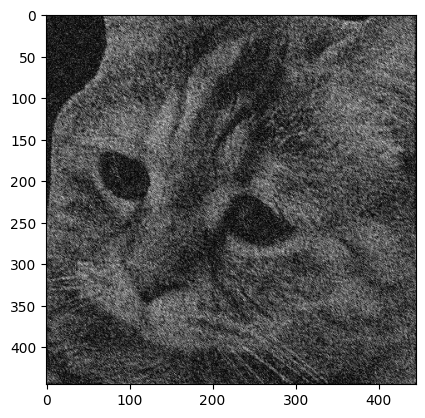

In [42]:
plt.imshow(denoisy, cmap='gray')

In [44]:
cv2.PSNR(img, denoisy)

16.351239000900435

### Using built-in package

In [49]:
from scipy.signal import wiener
denoisy = wiener(noisy, (5, 5))

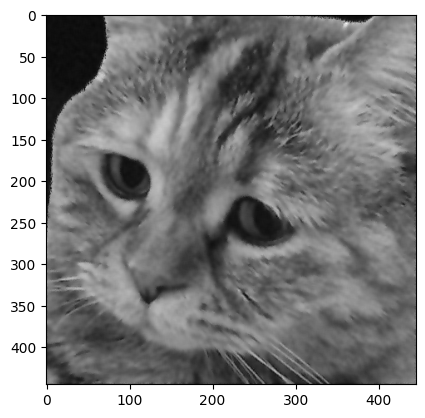

In [50]:
plt.imshow(denoisy, cmap='gray')

### Horizontal blur image with guassian noise

In [52]:
horz_blur = np.zeros((7, 7))
horz_blur = cv2.line(horz_blur, pt1=(7,3), pt2=(0,3), color=(255,), thickness=1)

In [46]:
kernel_size = 11
horz_blur = np.ones((1, kernel_size), np.float32) / kernel_size

In [50]:
mbimg = cv2.filter2D(img, ddepth=-1, kernel=horz_blur)

In [51]:
mbimg = cv2.add(mbimg, gaussian)

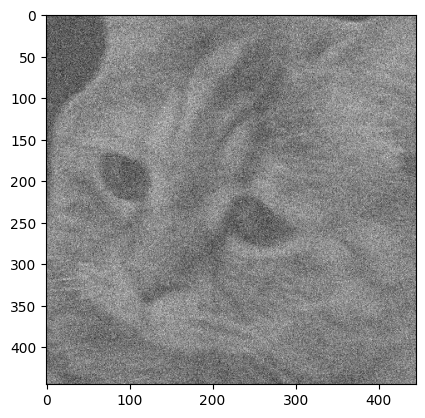

In [52]:
plt.imshow(mbimg, cmap='gray')

In [94]:
denoisy = wiener_filter(mbimg, horz_blur, 0.5)

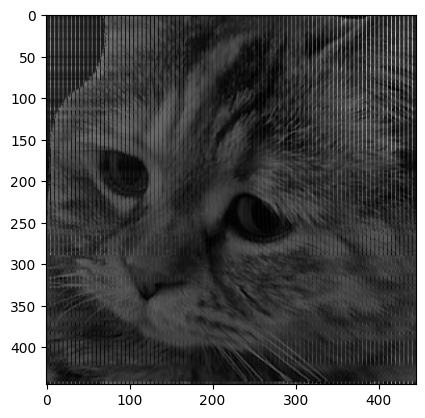

In [ ]:
plt.imshow(denoisy, cmap='gray')

In [ ]:
cv2.PSNR(denoisy, img)

15.600653333675202

In [ ]:
cv2.PSNR(mbimg, img)

-52.64030785790099

### Using built-in package

In [55]:
from scipy.signal import wiener
denoisy = wiener(mbimg, (7, 7))

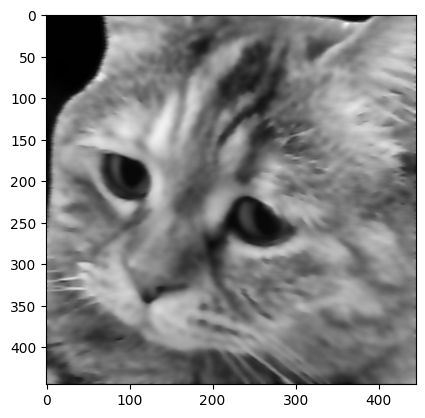

In [56]:
plt.imshow(denoisy, cmap='gray')

In [58]:
cv2.PSNR(denoisy, img)

-55.506587831205394

## MAP Estimation

100%|██████████| 200/200 [00:03<00:00, 50.85it/s]


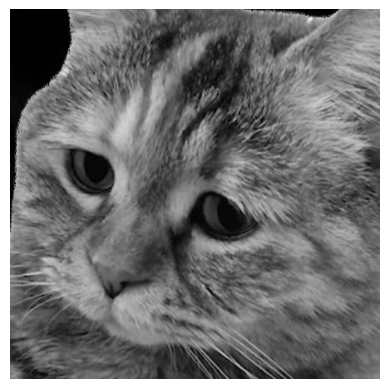

In [ ]:
from tqdm import tqdm

def likelihood(noisy_image, clean_image, noise_sigma):
    diff_squared  = (noisy_image - clean_image) ** 2
    likelihood = (1 / np.sqrt(2 * np.pi * noise_sigma**2)) * np.exp(-(diff_squared) / (2 * noise_sigma**2))
    return likelihood

def gaussian_prior(clean_image, prior_mean, prior_var):
    prior_prob = (1 / np.sqrt(2 * np.pi * prior_var**2)) * np.exp(-((clean_image - prior_mean)**2) / (2 * prior_var**2))
    return prior_prob

def map_estimation(noisy_image, noise, prior_var):
    num_iterations=200
    step_size=0.05
    # clean_image = noisy_image.copy()
    clean_image = cv2.subtract(noisy_image, noise)
    lpsnr = []
    for _ in tqdm(range(num_iterations)):
        likelihood_gradient = likelihood(noisy_image, clean_image, prior_var)
        prior_var += gaussian_prior(clean_image, clean_image.mean(), clean_image.var())
        clean_image += step_size * (likelihood_gradient + prior_var)
        # print(np.sum(prior_var))
    return clean_image, Slpsnr


noise = gaussian
prior_var = 0.5

denoise,lpsnr = map_estimation(noisy, noise, prior_var)

plt.imshow(denoise, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
cv2.PSNR(denoise, img)

33.7444124242205

In [ ]:
cv2.PSNR(noisy, img)

28.137914900258423

100%|██████████| 200/200 [00:02<00:00, 81.69it/s]


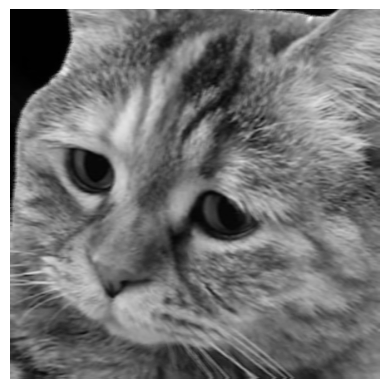

In [ ]:
noise = gaussian
prior_var = 0.5

denoise,lpsnr = map_estimation(mbimg, noise, prior_var)


plt.imshow(denoise, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
cv2.PSNR(denoise, img)

-52.64041065910093

## DL Model

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import fashion_mnist

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
num_pixels = x_train.shape[1] * x_train.shape[2]
x_train = x_train.reshape(x_train.shape[0], num_pixels).astype('float32')
x_test = x_test.reshape(x_test.shape[0], num_pixels).astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [8]:
import numpy as np
mean = 0
sigma = 100 ** 0.5
# gaussian = np.random.normal(mean, sigma, img.shape)#.astype(np.uint8)

In [18]:
noise_factor = 0.2
x_train_noisy = cv2.add(x_train, numpy.random.normal(loc=0.0, scale=1.0, size=x_train.shape).astype(np.float32))
x_test_noisy = cv2.add(x_test, noise_factor * numpy.random.normal(loc=0.0, scale=1.0, size=x_test.shape).astype(np.float32))

In [19]:
model = Sequential()
model.add(Dense(700, input_dim=num_pixels, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(700, activation='relu'))
model.add(Dense(784, activation='sigmoid'))

In [20]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
model.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0339 - val_loss: 0.0382
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0268 - val_loss: 0.0342
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0247 - val_loss: 0.0357
Epoch 4/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0232 - val_loss: 0.0354
Epoch 5/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0221 - val_loss: 0.0352


In [22]:
pred = model.predict(x_test_noisy)

313/313 [==============================] - 1s 4ms/step


In [26]:
x_test = numpy.reshape(x_test, (10000,28,28)) *255
pred = numpy.reshape(pred, (10000,28,28)) *255
x_test_noisy = numpy.reshape(x_test_noisy, (-1,28,28)) *255

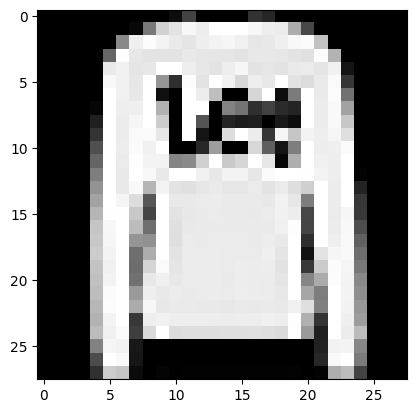

In [34]:
#Original
plt.imshow(x_test[1,:,:], cmap='gray')

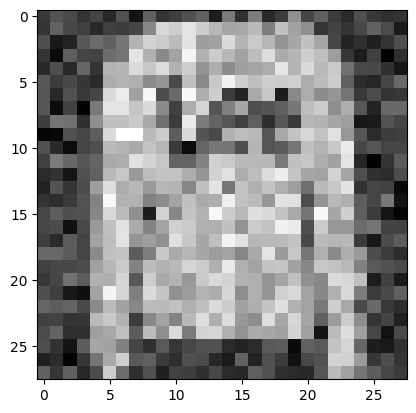

In [37]:
#Noisy
plt.imshow(x_test_noisy[1,:,:], cmap='gray')

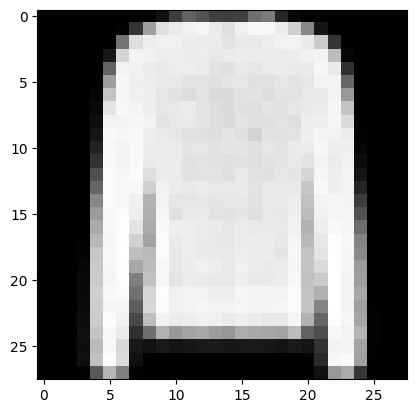

In [38]:
#Predicted
plt.imshow(pred[1,:,:], cmap='gray')